## Introduction

Gravitational waves are the ripples in space-time created by accelerating massive objects. They were recently directly measured by the Laser Interferometer Gravitational-Wave Observatory (LIGO); the waves themselves were produced by the coalescence and merger of two 30 M${}_{\odot}$ black holes. You can read all about it here: http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102.

Surprisingly, the range of frequencies detectable with LIGO is a very close analog to range of frequencies audible to humans. We build on this analogy here by making the gravitational-wave signal from a binary black hole "audible".

<img src="https://people.ece.cornell.edu/land/courses/ece5030/FinalProjects/s2014/kkp37_rjs483/kkp37_rjs483/ECE%205030%20Audiogram_files/human%20hearing.gif">

<img src="http://journals.aps.org/prl/article/10.1103/PhysRevLett.116.061102/figures/3/medium">

### Gravitational Wave Data

Time series of "strain" (the effect of a gravitational wave on an interferometer) is available for this event, and can be downloaded from the LIGO LOSC page: https://losc.ligo.org/events/GW150914/

Here is a few representations of the signal as "heard" by the interferometers:

<img src="http://journals.aps.org/prl/article/10.1103/PhysRevLett.116.061102/figures/1/medium">

In [13]:
import wave
import numpy
import math

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
%%bash
# Reconstructed (template -- no noise)
if [ ! -f fig2-unfiltered-template-reconstruction-H.txt ]; then
    wget https://losc.ligo.org/s/events/GW150914/P150914/fig2-unfiltered-template-reconstruction-H.txt
fi

# Denoised signal (Hanford site)
if [ ! -f fig1-observed-H.txt ]; then
    wget https://losc.ligo.org/s/events/GW150914/P150914/fig1-observed-H.txt
fi

# Denoised signal (Livingston site)
if [ ! -f fig1-observed-L.txt ]; then
    wget https://losc.ligo.org/s/events/GW150914/P150914/fig1-observed-L.txt
fi

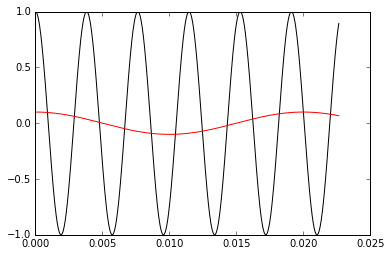

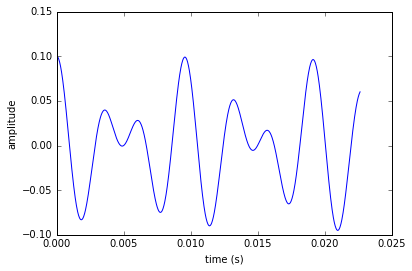

In [36]:
# pure tone
freq = 261.6 # Hz (Middle C)
amp_freq = 50
#freq = 1400 # Hz ISCO
duration = 5 # s
sampling_rate = 44100 # audio is typically encoded at 44.1 kHz
t = numpy.linspace(0, duration, sampling_rate * duration)
t = t.astype(numpy.float32)
data = numpy.cos(2 * numpy.pi * t * freq)
data2 = 0.1*numpy.cos(2 * numpy.pi * t * amp_freq)

plt.plot(t[:1000], data[:1000], "k-")
plt.plot(t[:1000], data2[:1000], "r-")
plt.figure()
plt.plot(t[:1000], data[:1000]*data2[:1000], "b-")
plt.xlabel("time (s)")
plt.ylabel("amplitude")

wout = wave.open("pure_tone.wav", "w")
wout.setnchannels(1) # mono
wout.setsampwidth(4) # 32 bit audio
wout.setframerate(sampling_rate)
wout.writeframes(data.data)
wout.close()

In [4]:
%%html
<iframe src="https://commons.wikimedia.org/wiki/File%3AAudio_Frequency_tone%2C_Middle_C%2C_C4%2C_261.63hz.ogg?embedplayer=yes" width="120" height="120" frameborder="0" ></iframe>

In [6]:
%%bash
# OS X only
file pure_tone.wav
time afplay pure_tone.wav

pure_tone.wav: RIFF (little-endian) data, WAVE audio, Microsoft PCM, 32 bit, mono 44100 Hz



real	0m5.496s
user	0m0.060s
sys	0m0.034s


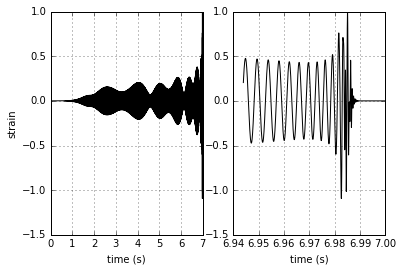

In [6]:
sampling_rate = 16384 * 4

n_wind = 128
wind = numpy.linspace(0, 127, n_wind)

try:
    import lal, lalsimulation
    
    m1, m2 = 1.4 * lal.MSUN_SI, 10 * lal.MSUN_SI
    s1x, s1y, s1z = 0.5, 0.5, 0.0
    #s1x, s1y, s1z = 0.0, 0.0, 0.0
    s2x, s2y, s2z = 0.9, 0.0, 0.0

    approx = lalsimulation.GetApproximantFromString("IMRPhenomPv2")
    hp, hx = lalsimulation.SimInspiralTD(0, 1.0/sampling_rate,
                                     m1, m2,
                                     s1x, s1y, s1z,
                                     s2x, s2y, s2z,
                                     40, 10,
                                     1e6*lal.PC_SI, 0.0,
                                     1.0, 0.0, 
                                     0.0, None, None, -1, 7, approx)

    tmplt = hp.data.data  + hx.data.data
    
    # Window the end to remove sharp edges
    tmplt[-n_wind:] *= 1 - numpy.cos(2 * numpy.pi * wind / (n_wind - 1))
    
    # Save data so that you don't need the library to generate it any more
    with open("nsbh_tmplt.npy", "w") as fout:
        numpy.save(fout, tmplt)
        
    t = numpy.linspace(0, len(hp.data.data) / sampling_rate, len(hp.data.data), dtype = numpy.float32)

except ImportError:
    # Read the file back in
    tmplt = numpy.load("nsbh_tmplt.npy")
    t = numpy.linspace(0, len(tmplt) / sampling_rate, len(tmplt), dtype = numpy.float32)

tmplt /= tmplt.max()
tmplt = tmplt.astype(numpy.float32)

plt.subplot(1, 2, 1)
plt.plot(t, tmplt, "k-")
plt.grid()
# Note that the time is actually relative to a given GPS time recorded by a instrument
plt.xlabel("time (s)")
plt.ylabel("strain")

# Plot the end of the waveform, where we've tapered
plt.subplot(1, 2, 2)
plt.plot(t[-32*n_wind:], tmplt[-32*n_wind:], "k-")
plt.grid()
plt.xlabel("time (s)")

tmplt.dtype = numpy.uint32

wout = wave.open("NSBH_noise_free.wav", "w")
wout.setnchannels(1) # mono
wout.setsampwidth(4) # 32 bit audio
wout.setframerate(sampling_rate)
# We use the underlying data buffer from the numpy array to write the data
wout.writeframes(tmplt.data)
wout.close()

# Now for stereo
wout = wave.open("NSBH_noise_free_stereo.wav", "w")
wout.setnchannels(2) # mono
wout.setsampwidth(4) # 32 bit audio
wout.setframerate(sampling_rate)
# The trick is that we have to interleave the data, that is, place each L/R sample next to each other
tmplt_intr = numpy.array((tmplt, tmplt)).T.flatten()
wout.writeframes(tmplt_intr.data)
wout.close()

In [10]:
%%bash
# OS X only
file NSBH_noise_free.wav
time afplay NSBH_noise_free.wav

NSBH_noise_free.wav: RIFF (little-endian) data, WAVE audio, Microsoft PCM, 32 bit, mono 65536 Hz



real	0m8.172s
user	0m0.120s
sys	0m0.049s


In [11]:
%%bash
# OS X only
file NSBH_noise_free_stereo.wav
time afplay NSBH_noise_free_stereo.wav

NSBH_noise_free_stereo.wav: RIFF (little-endian) data, WAVE audio, Microsoft PCM, 32 bit, stereo 65536 Hz



real	0m8.185s
user	0m0.119s
sys	0m0.050s


In [9]:
# Read the file back in -- we messed with it before, we want a pristine version
tmplt = numpy.load("nsbh_tmplt.npy")

# Get the next power of 2
zpad_length = int(2**math.ceil(math.log(len(tmplt), 2)))
print len(tmplt), zpad_length

# Length expressed in units of time (seconds)
len_t = zpad_length / float(sampling_rate)

511881 524288


[]

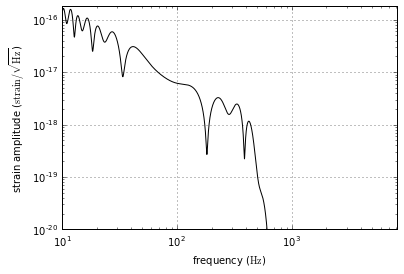

In [10]:
# Fourier domain analysis
# When the numpy FFT routine is called, one can give it a length to work with
# Rather than using the actual length

tmplt_fd = numpy.fft.rfft(tmplt, zpad_length)

frequencies = numpy.linspace(0, 16384./2, len(tmplt_fd))
plt.plot(frequencies, numpy.abs(tmplt_fd), 'k-')
plt.xlim([1e1, 8192])
plt.ylim([1e-20, None])
plt.grid()
plt.xlabel(r"frequency ($\mathrm{Hz}$)")
plt.ylabel(r"strain amplitude ($\mathrm{strain}/\sqrt{\mathrm{Hz}}$)")
plt.loglog()

## Convert the "best fit" template to audio

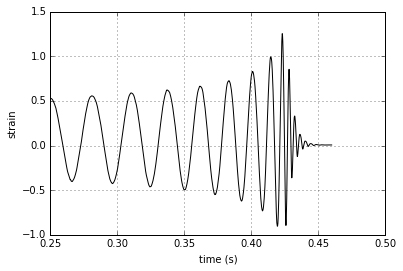

In [31]:
# Import template data
t, _, tmplt = numpy.loadtxt("fig2-unfiltered-template-reconstruction-H.txt", unpack=True, dtype=numpy.float32)
sampling_rate = 1.0/(t[1] - t[0])
plt.plot(t, tmplt, "k-")
plt.grid()
# Note that the time is actually relative to a given GPS time recorded by a instrument
plt.xlabel("time (s)")
plt.ylabel("strain")

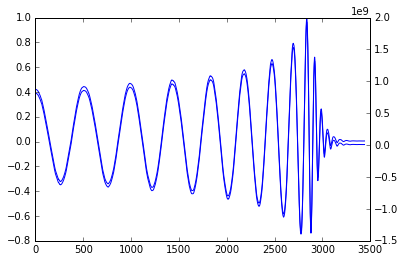

In [27]:
sampling_rate = 16384

tmplt /= tmplt.max()
plt.plot(tmplt)
tmplt *= int(2**31 * 90./100)
tmplt = tmplt.astype(numpy.int32)
plt.twinx()
plt.plot(tmplt)

wout = wave.open("GW150914_noise_free.wav", "w")
wout.setnchannels(1) # mono
wout.setsampwidth(4) # 32 bit audio
wout.setframerate(sampling_rate)
wout.writeframes(tmplt.data)
wout.close()

In [28]:
%%bash
# OS X only
file GW150914_noise_free.wav
time afplay GW150914_noise_free.wav

GW150914_noise_free.wav: RIFF (little-endian) data, WAVE audio, Microsoft PCM, 32 bit, mono 16384 Hz



real	0m0.729s
user	0m0.035s
sys	0m0.023s


## Convert the filtered data to audio

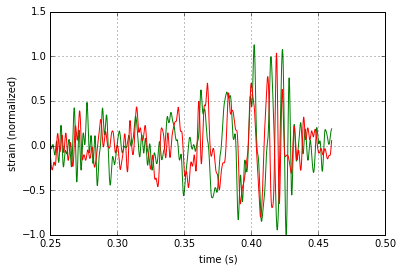

In [14]:
# Import template data
t, h_data = numpy.loadtxt("fig1-observed-H.txt", unpack=True, dtype=numpy.float32)
t, l_data = numpy.loadtxt("fig1-observed-L.txt", unpack=True, dtype=numpy.float32)

plt.plot(t, h_data, "g-")
plt.plot(t, l_data, "r-")
plt.grid()
# Note that the time is actually relative to a given GPS time recorded by a instrument
plt.xlabel("time (s)")
plt.ylabel("strain (normalized)")


sampling_rate = 1.0/(t[1] - t[0])

## Write the signal in stereo

We had two instruments participating in the detection: one in Hanford, Washington, and one in Livingston, Louisiana. While they both "hear" the signal differently because of their separate locations, they don't have the same directional sensitivity our ears do.

So, we'll fake it and pretend that we do. :)

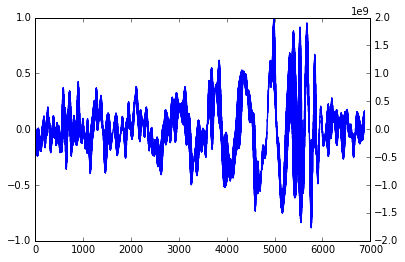

In [15]:
# Interleave and normalize the volume
tmplt = numpy.array((h_data, l_data)).T.flatten()
tmplt /= tmplt.max()
plt.plot(tmplt)
tmplt *= int(2**31 * 90./100)
tmplt = tmplt.astype(numpy.int32)
plt.twinx()
plt.plot(tmplt)
tmplt = tmplt.copy(order='C')

wout = wave.open("GW150914_stereo_filtered.wav", "w")
wout.setnchannels(2) # stereo
wout.setsampwidth(4) # 32 bit audio
wout.setframerate(sampling_rate)
wout.writeframes(tmplt.data)
wout.close()

In [30]:
%%bash
# OS X only
time afplay GW150914_noise_free.wav
time afplay GW150914_stereo_filtered.wav


real	0m0.605s
user	0m0.029s
sys	0m0.019s

real	0m0.595s
user	0m0.027s
sys	0m0.017s
